In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from encoder.digit_encoder import small_int_vector_asimage
from sparse_causal_model_learner_rl.trainable.combined import FCCombinedModel

In [2]:
def get_x(n_samples=1000):
    values = np.random.randint(low=0, high=10, size=(n_samples, 5))
#     print(values)
    imgs = [small_int_vector_asimage(v, max_digits=1) for v in values]
    return np.array(imgs), values

In [3]:
arr, vals = get_x()
X = torch.from_numpy(arr).cuda()
vals = torch.from_numpy(vals * 1.0).cuda()

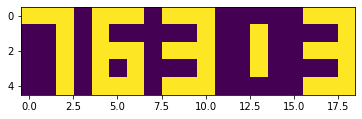

In [4]:
plt.imshow(X[0].detach().cpu().numpy())

In [5]:
shape = X[0].detach().cpu().numpy().shape
size = np.prod(shape)
print(shape, size)

(5, 19) 95


In [6]:
import ray
ray.shutdown()
ray.init(ignore_reinit_error=True)

@ray.remote
class DataGenerator():
    def __init__(self):
        pass
    def get_data(self, n=32):
        arr, vals = get_x(n)
        return arr, vals
    
workers = [DataGenerator.remote() for _ in range(5)]

refs = []

def get_data_ray(z=32, qlen=100):
    global refs
    while len(refs) < qlen:
        idx = np.random.choice(len(workers))
        refs.append(workers[idx].get_data.remote(z))

    ready, remaining = ray.wait(list(refs))
    assert len(ready) == 1
    arr, vals = ray.get(ready[0])
    refs = remaining
    return arr, vals

2021-02-20 07:15:55,896	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266


In [7]:
class Dec(nn.Module):
    def __init__(self):
        super(Dec, self).__init__()
        # 200, 100, 50, 10
        self.fc1 = nn.Linear(size, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.fc5 = nn.Linear(10, 8)
        self.act = nn.Tanh()
    def forward(self, x):
#         x = x.flatten(start_dim=1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.fc5(x)
        return x
    
class Rec(nn.Module):
    def __init__(self):
        super(Rec, self).__init__()
        # 200, 100, 50
        self.fc1 = nn.Linear(8, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, size)
        self.act = nn.Tanh()
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
#         x = x.view(x.shape[0], *shape)
        return x
    
# dec = Dec().cuda()
# rec = Rec().cuda()

dec = FCCombinedModel(input_shape=(size,),
                      output_shape=(5,),
                      input_reshape=True,
                      activation_cls=nn.LeakyReLU,
                      hidden_sizes=[128, 64, 64, 64]).cuda()


rec = FCCombinedModel(input_shape=(5,),
                      output_shape=(size,),
                      input_reshape=True,
                      skipconns=None,#[False, True, True, False],
                      add_input_batchnorm=True,
                      activation_cls=[nn.LeakyReLU,
                                      nn.Tanh,
                                      nn.Tanh,
                                      None],
                      hidden_sizes=[128, 64, 32]).cuda()

[False, False, False, False, False]
[95, 128, 64, 64, 64, 1] 5
[False, False, False, False]
[5, 128, 64, 32, 1] 95


In [8]:
(rec(dec(X.flatten(start_dim=1))).view(X.shape[0], *shape) - X).flatten(start_dim=1).pow(2).sum(1).mean(0)

tensor(51.2676, device='cuda:0', grad_fn=<MeanBackward1>)

In [9]:
stds = X.std(0, keepdim=True)
stds = torch.where(stds < 1e-8, torch.ones_like(stds), stds)
stds = stds.detach()

In [10]:
val_std = vals.std(0, keepdim=True)

(array([15., 35., 25.,  0.,  0.,  0.,  0.,  0.,  0., 20.]),
 array([0.29336163, 0.36402547, 0.4346893 , 0.50535315, 0.57601696,
        0.64668083, 0.71734464, 0.7880085 , 0.8586723 , 0.9293362 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

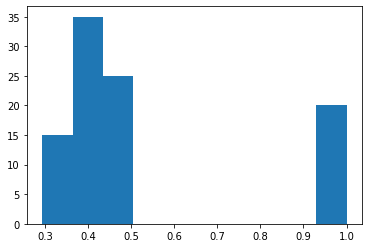

In [11]:
plt.hist(stds.flatten().detach().cpu().numpy())

In [12]:
opt = torch.optim.Adam(list(rec.parameters()) + list(dec.parameters()),
                      lr=1e-3)

In [13]:
def loss():
    Xrec = rec(dec(X.flatten(start_dim=1))).view(X.shape[0], *shape)
    delta = (X - Xrec).flatten(start_dim=1)
    delta = delta / stds.flatten(start_dim=1)
    l = delta.pow(2).sum(1).mean(0)
    
    acc = (1. * ((X > 0.5) == (Xrec > 0.5))).mean()
    
    return l, acc

In [14]:
losses = []
accs = []

In [15]:
for i in tqdm(range(5000)):
    if i % 10 == 0:
        arr, vals = get_data_ray(5000)
        X = torch.from_numpy(arr).cuda()
        vals = torch.from_numpy(vals * 1.0).cuda()
    
    opt.zero_grad()
    l, acc = loss()
    l.backward()
    opt.step()
    
    losses.append(l.item())
    accs.append(acc)

/home/sergei/miniconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  after removing the cwd from sys.path.


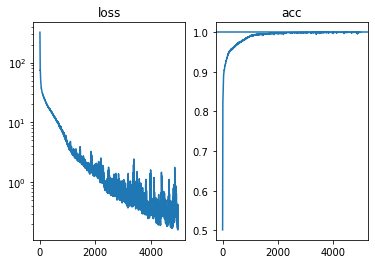

In [16]:
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('loss')
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.plot(accs)
plt.title('acc')
plt.axhline(1)

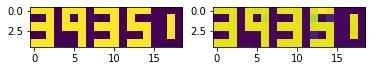

In [17]:
idx = np.random.choice(len(X))
Xrec = rec(dec(X.flatten(start_dim=1))).view(X.shape[0], *shape)
plt.subplot(1, 2, 1)
plt.imshow(X[idx].detach().cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(Xrec[idx].detach().cpu().numpy())

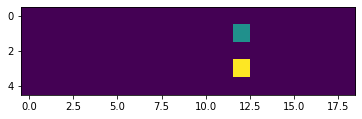

In [18]:
plt.imshow(((X - Xrec).pow(2).mean(0).detach().cpu().numpy() * 255).astype(np.uint8))

# Predicting features

In [14]:
dec = FCCombinedModel(input_shape=(size,),
                      output_shape=(5,),
                      input_reshape=True,
                      activation_cls=nn.LeakyReLU,
                      hidden_sizes=[128, 64, 64, 64]).cuda()


[False, False, False, False, False]
[95, 128, 64, 64, 64, 1] 5


In [15]:
opt = torch.optim.Adam(list(dec.parameters()),
                      lr=1e-3)

In [16]:
vals.shape

torch.Size([1000, 5])

In [17]:
def loss():
    vals_pred = dec(X.flatten(start_dim=1))
#     print(vals_pred.shape)
    delta = (vals - vals_pred).flatten(start_dim=1)
    delta = delta / val_std
    l = delta.pow(2).sum(1).mean(0)
    
    return l

2021-02-20 05:50:51,450	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '172.18.157.129',
 'raylet_ip_address': '172.18.157.129',
 'redis_address': '172.18.157.129:6379',
 'object_store_address': '/tmp/ray/session_2021-02-20_05-50-50_844925_8853/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-20_05-50-50_844925_8853/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-02-20_05-50-50_844925_8853',
 'metrics_export_port': 61665,
 'node_id': '2dc7bc1ec49b6549c5199284ace315f2ace98907'}

In [22]:
losses = []

In [23]:
opt = torch.optim.Adam(list(dec.parameters()),
                      lr=1e-3)

In [27]:
for i in tqdm(range(10000)):
    if i % 1 == 0:
        arr, vals = get_data_ray(5000)
        X = torch.from_numpy(arr).cuda()
        vals = torch.from_numpy(vals * 1.0).cuda()
    
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    
    losses.append(l.item())

KeyboardInterrupt: 

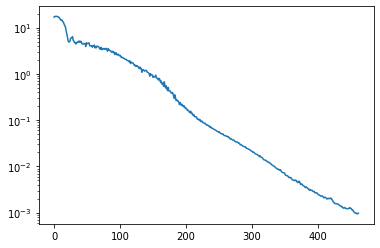

In [28]:
plt.plot(losses)
plt.yscale('log')

tensor([4., 4., 3., 9., 0.], device='cuda:0', dtype=torch.float64)
tensor([[ 3.9576e+00,  4.0210e+00,  3.0018e+00,  9.0238e+00, -6.4272e-03]],
       device='cuda:0', grad_fn=<ViewBackward>)


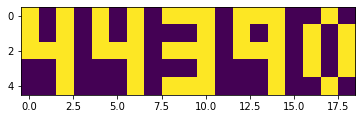

In [29]:
print(vals[0])
print(dec(X[0:1].flatten(start_dim=1)))
plt.imshow(arr[0])

In [30]:
arr, vals = get_x(1024)
X = torch.from_numpy(arr).cuda()
vals = torch.from_numpy(vals * 1.0).cuda()
(torch.round(dec(X.flatten(start_dim=1))) - vals).pow(2).mean(0)

tensor([0., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [31]:
import gin
gin.enter_interactive_mode()

Need to decrease lr to have results.

In [32]:
rec = FCCombinedModel(input_shape=(5,),
                      output_shape=(size,),
                      input_reshape=True,
                      skipconns=None,#[False, True, True, False],
                      add_input_batchnorm=True,
                      activation_cls=[nn.LeakyReLU,
                                      nn.Tanh,
                                      nn.Tanh,
                                      None],
                      hidden_sizes=[128, 64, 32]).cuda()

[False, False, False, False]
[5, 128, 64, 32, 1] 95


In [33]:
len(list(rec.parameters()))

10

In [34]:
opt = torch.optim.Adam(list(rec.parameters()),
                      lr=1e-3)

In [35]:
# opts = [torch.optim.Adam([z], lr=1e-3) for z in list(rec.parameters())]

In [36]:
def loss():
    Xrec = rec(vals / 10 - 1).view(X.shape[0], *shape)
    delta = (X - Xrec).flatten(start_dim=1)
    delta = delta / stds.flatten(start_dim=1)
    l = delta.abs().pow(2).sum(1).mean(0)
    
    acc = (1. * ((X > 0.5) == (Xrec > 0.5))).mean()
    
    return l, acc

In [37]:
losses = []
accs = []

In [52]:
for i in tqdm(range(10000)):
    if i % 1 == 0:
        arr, vals = get_data_ray(5000)
        X = torch.from_numpy(arr).cuda()
        vals = torch.from_numpy(vals * 1.0).to(torch.float32).cuda()
    
#     for opt_ in opts:
    opt_ = opt
    opt_.zero_grad()
    l, acc = loss()
    l.backward()
    opt_.step()
    
    losses.append(l.item())
    accs.append(acc)

KeyboardInterrupt: 

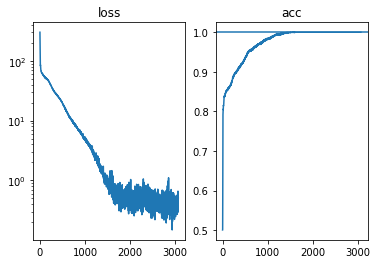

In [53]:
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('loss')
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.plot(accs)
plt.title('acc')
plt.axhline(1)

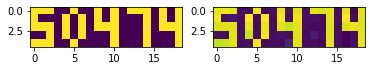

In [54]:
idx = np.random.choice(len(X))
Xrec = rec(vals / 50 - 1).view(X.shape[0], *shape)
plt.subplot(1, 2, 1)
plt.imshow(X[idx].detach().cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(Xrec[idx].detach().cpu().numpy())

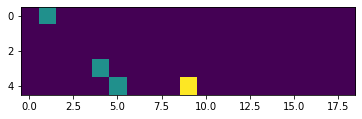

In [55]:
plt.imshow(((X - Xrec).pow(2).mean(0).detach().cpu().numpy() * 255).astype(np.uint8))

In [307]:
%timeit small_int_vector_asimage([1, 2, 3, 4, 5])

2.36 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [321]:
%timeit small_int_vector_asimage([1, 2, 3, 4, 5])

12.3 µs ± 722 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [311]:
%timeit np.zeros((5, 3 * 5 + 5 - 1), dtype=np.float32)

823 ns ± 77.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [316]:
%timeit np.zeros((5, 3 * 5 + 5 - 1), dtype=np.float32)[:, :] = 1

1.7 µs ± 144 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [317]:
%timeit np.allclose(np.round(5.0), 5.0)

96.4 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [320]:
%timeit abs(round(5.0) - 5.0) < 1e-8

354 ns ± 44.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


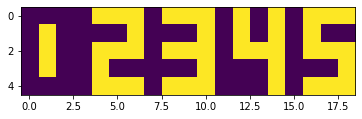

In [322]:
plt.imshow(small_int_vector_asimage([1, 2, 3, 4, 5]))